# Load libraries and check HW

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import timeit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Tue Jul 25 18:56:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Design datasets

In [ ]:
!pip install ultralytics lapx supervision==0.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.0/608.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.7 MB/s eta 0:00:00


In [ ]:
%cd /content/drive/MyDrive/TFM

/content/drive/MyDrive/TFM


In [ ]:
HOME = os.getcwd()
print(HOME)

import supervision as sv
print("supervision.__version__:", sv.__version__)

# Check GPU
import torch
print('Working with GPU:')
print(torch.cuda.is_available())

# Load libraries
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics YOLOv8.0.142 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.3/78.2 GB disk)


In [ ]:
%cd /content/drive/MyDrive/TFM/team_data/raw2

/content/drive/MyDrive/TFM/team_data/raw2


In [ ]:
# load a YOLOv8 custom model
model = YOLO(f"{HOME}/data/model/y8l-0307.pt")

# SETTINGS
SOURCE_VIDEO_PATH = f"{HOME}/team_data/raw2/game4.mp4"
if os.path.isdir(f"{HOME}/data/raw_video") == False:
  os.mkdir(f"{HOME}/data/raw_video")

# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
print(CLASS_NAMES_DICT)

# class_ids of interest - player and ball-handler
CLASS_ID = [0,2]

sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)


# INFERENCE
# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

idx_1 = 0

# Detect and track objects using ultralytics SDK
for result in model.predict(source=SOURCE_VIDEO_PATH, save=True, stream=True, agnostic_nms=True):

  idx_1 += 1

  frame = result.orig_img
  detections = sv.Detections.from_yolov8(result)

  # Filtering undesired classes
  detections = detections[detections.class_id != 1]

  frame_h, frame_w, _ = frame.shape

  idx_2 = 0

  for xyxy in detections.xyxy:
    # Crop the frame
    # all numbers positive integers
    list1 = np.asarray(xyxy, dtype = 'int')
    x1,y1,x2,y2 = [(i > 0) * i for i in list1]

    # hight and width
    h = y2-y1
    w = x2-x1

    # make sure all positive
    a = int(max(0, y1+0.15*h))
    b = int(min(frame_h, y2-0.5*h))
    c = int(max(0, x1+0.25*w))
    d = int(min(frame_w, x2-0.25*w))

    crop = frame[a:b,c:d]

    idx_2 += 1

    filename = f"{idx_1}"+f"{idx_2}"+'.jpg'
    cv2.imwrite(filename, crop)

{0: 'ball-handler', 1: 'head', 2: 'player'}


Streaming output truncated to the last 5000 lines.
video 1/1 (11422/16419) /content/drive/MyDrive/TFM/team_data/raw2/game4.mp4: 384x640 6 players, 39.9ms
video 1/1 (11423/16419) /content/drive/MyDrive/TFM/team_data/raw2/game4.mp4: 384x640 6 players, 39.0ms
video 1/1 (11424/16419) /content/drive/MyDrive/TFM/team_data/raw2/game4.mp4: 384x640 1 ball-handler, 8 players, 39.1ms
video 1/1 (11425/16419) /content/drive/MyDrive/TFM/team_data/raw2/game4.mp4: 384x640 1 ball-handler, 6 players, 39.2ms
video 1/1 (11426/16419) /content/drive/MyDrive/TFM/team_data/raw2/game4.mp4: 384x640 2 ball-handlers, 7 players, 41.0ms
video 1/1 (11427/16419) /content/drive/MyDrive/TFM/team_data/raw2/game4.mp4: 384x640 2 ball-handlers, 8 players, 41.4ms
video 1/1 (11428/16419) /content/drive/MyDrive/TFM/team_data/raw2/game4.mp4: 384x640 1 ball-handler, 8 players, 40.1ms
video 1/1 (11429/16419) /content/drive/MyDrive/TFM/team_data/raw2/game4.mp4: 384x640 1 ball-handler, 7 players, 45.8ms
video 1/1 (11430/16419) /co

# Load Files

In [ ]:
%cd /content/drive/MyDrive/TFM/team_data

/content/drive/MyDrive/TFM/team_data


In [ ]:
image_dataset_dir_warriors = "/content/drive/MyDrive/TFM/team_data/warriors2/train"
image_dataset_dir_celtics = "/content/drive/MyDrive/TFM/team_data/celtics2/train"

In [ ]:
def dataset_creation(image_dataset_dir):
  dataset = []
  print(len(os.listdir(image_dataset_dir)))
  for name in os.listdir(image_dataset_dir):
    im = cv2.imread(f"{name}")
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    dataset.append(im)
  return dataset

In [ ]:
%cd /content/drive/MyDrive/TFM/team_data/warriors2/train

/content/drive/MyDrive/TFM/team_data/warriors2/train


In [ ]:
print('warriors')
dataset_warriors = dataset_creation(image_dataset_dir_warriors)

warriors
760


In [ ]:
%cd /content/drive/MyDrive/TFM/team_data/celtics2/train

/content/drive/MyDrive/TFM/team_data/celtics2/train


In [ ]:
print('celtics')
dataset_celtics = dataset_creation(image_dataset_dir_celtics)

celtics
760


# Calculate MAP

In [ ]:
# calculate channel mean per image
def channel_img_mean(dataset):
  dataset_mean = []
  print(dataset_mean)
  for image in dataset:
    img_mean = np.mean(image, axis = (0,1))/255
    dataset_mean.append(img_mean)
  dataset_mean = np.array(dataset_mean)
  return dataset_mean

In [ ]:
# Calculate mean values for one image
def channel_img_mean_2(image):
  img_mean = np.mean(image, axis = (0,1))/255
  return img_mean

In [ ]:
def fisher(feat_A, feat_B, classA, classB):
  # Mean and Scatter of A
  clA_mean = np.mean(feat_A, axis=0)
  print("RGB channels' means of "+ str(classA))
  print(clA_mean)
  sA = np.cov(np.transpose(feat_A))
  sA = sA*feat_A.shape[0]
  print("Scatter matrix for "+ str(classA))
  print(sA)

  # Mean and Scatter of B
  clB_mean = np.mean(feat_B, axis=0)
  print("RGB channels' means of "+ str(classB))
  print(clB_mean)
  sB = np.cov(np.transpose(feat_B))
  sB = sB*feat_B.shape[0]
  print("Scatter matrix for "+ str(classB))
  print(sB)

  # Max
  s = 1/2*(sA+sB)
  w_max = np.dot(np.linalg.inv(s),(clA_mean - clB_mean))
  print("w_max vector")
  print(w_max)

  # Projection
  tclA = np.zeros(feat_A.shape[0])
  for i in range(0,feat_A.shape[0]):
    tclA[i] = np.dot(w_max, feat_A[i])

  tclB = np.zeros(feat_B.shape[0])
  for i in range(0,feat_B.shape[0]):
    tclB[i] = np.dot(w_max, feat_B[i])

  buf0 = "Team " + classA
  buf1 = "Team " + classB
  plt.figure(figsize=(20,5))
  plt.hist(tclA, bins='auto', label=buf0)
  plt.hist(tclB, bins='auto', label=buf1)
  plt.title('Histogram of the projection')
  plt.legend()

  return tclA, tclB, w_max

In [ ]:
def threshold(tclA, tclB, classA, classB):
  # Intersection of the PDF
  tclA_mean = np.mean(tclA)
  tclA_std = np.std(tclA)
  tclB_mean = np.mean(tclB)
  tclB_std = np.std(tclB)

  #Polynomic coeficients
  p = np.empty(3)
  p[0] = 1/2*(tclB_std**2 - tclA_std**2)/(tclA_std**2 * tclB_std**2)
  p[1] = (tclB_mean*tclA_std**2 - tclA_mean*tclB_std**2)/(tclA_std**2 * tclB_std**2)
  p[2] = tclA_mean**2/(2*tclA_std**2) - tclB_mean**2/(2*tclB_std**2) + np.log(tclA_std/tclB_std)
  roots = np.roots(p)
  print(roots)

  # Threshold decition
  if (roots[0] >= tclA_mean and roots[0] >= tclB_mean) or (roots[0] <= tclA_mean and roots[0] <= tclB_mean):
    th = roots[1]
  else: th = roots[0]
  print("The threshold is:")
  print(th)

  bufA = "Team " + classA
  bufB = "Team " + classB

  plt.figure(figsize=(20,5))
  bins = 'auto'
  hist0, bin_edges0, empty0 = plt.hist(tclA, bins = bins, density= 'TRUE', color = 'lightsteelblue', label=bufA)
  bins0 = len(bin_edges0)-1
  hist1, bin_edges1, empty1 = plt.hist(tclB, bins = bins, density= 'TRUE', color = 'bisque', label=bufB)
  bins1 = len(bin_edges1)-1

  # Gaussian ditribution
  x0 = np.zeros(bins0)
  for i in range(bins0):
    x0[i] = (bin_edges0[i] + bin_edges0[i+1])/2
  x1 = np.zeros(bins1)
  for i in range(bins1):
    x1[i] = (bin_edges1[i] + bin_edges1[i+1])/2

  norm_dist0 = stats.norm.pdf(x0, tclA_mean, tclA_std)
  norm_dist1 = stats.norm.pdf(x1, tclB_mean, tclB_std)

  plt.plot(x0, norm_dist0, color = 'blue', linewidth=2, label='Team '+ classA +' Gaussian')
  plt.plot(x1, norm_dist1, color = 'darkorange', linewidth=2, label='Team '+ classB +' Gaussian')
  plt.axvline(th, color='k', linestyle='dashed', linewidth=1)
  plt.title("Threshold")
  plt.legend(loc="upper left")
  plt.show()

  return th



[]
(760, 3)
[]
(760, 3)


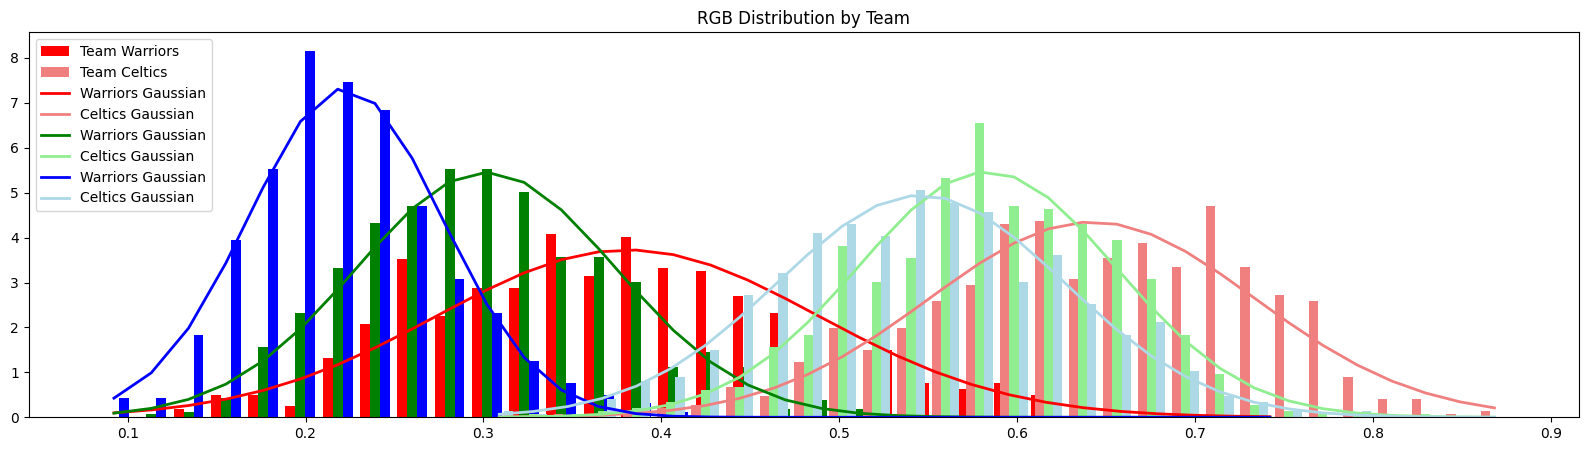

RGB channels' means of Warriors
[0.38101101 0.30149271 0.22226541]
Scatter matrix for Warriors
[[8.72237821 5.118289   3.80325037]
 [5.118289   4.06757636 2.8124756 ]
 [3.80325037 2.8124756  2.25732235]]
RGB channels' means of Celtics
[0.6421257  0.58291171 0.54590799]
Scatter matrix for Celtics
[[6.40768573 4.06062868 3.99789223]
 [4.06062868 4.04921051 4.09771065]
 [3.99789223 4.09771065 4.95688038]]
w_max vector
[ 0.02370197  0.01116409 -0.12604768]
[-0.02705948  0.01897853]
The threshold is:
-0.027059484986970958


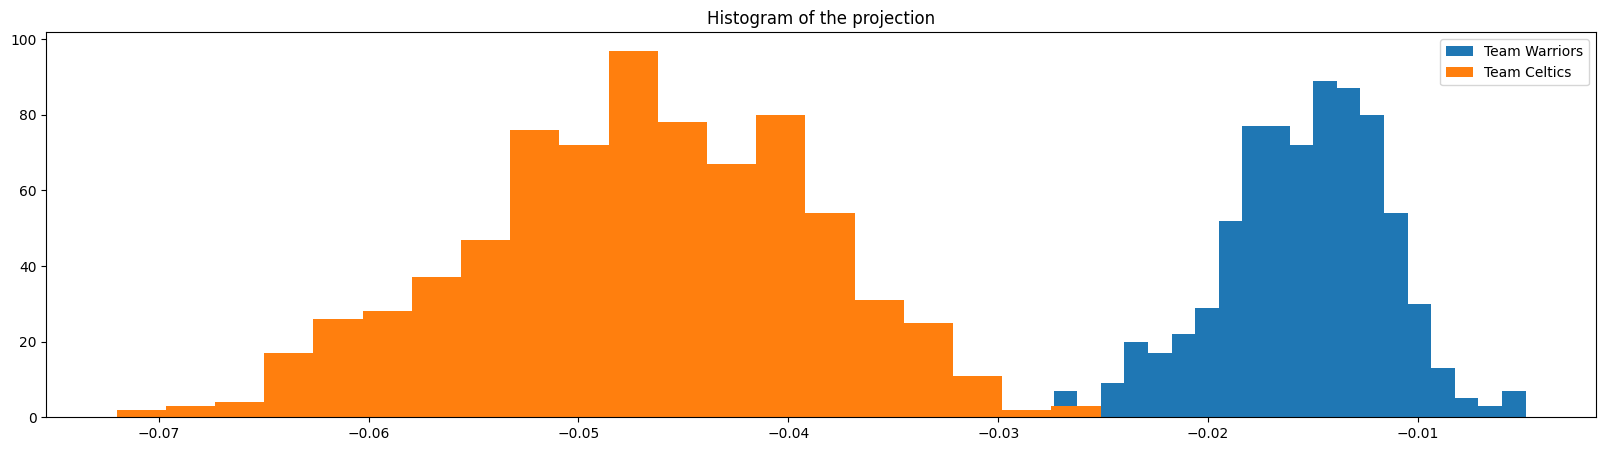

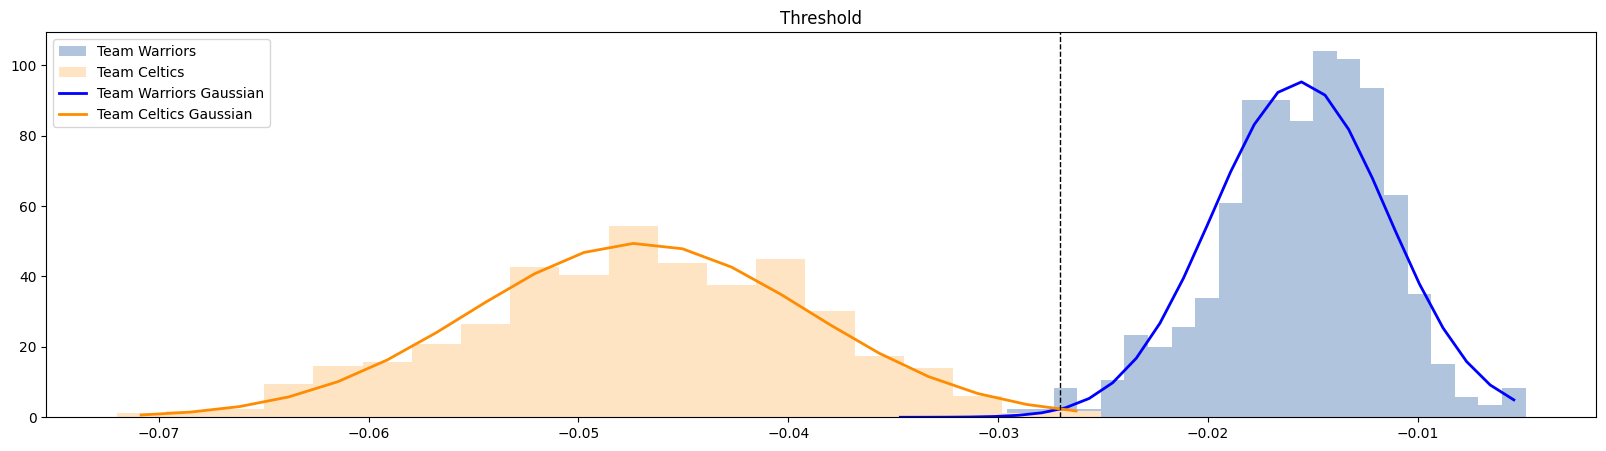

In [ ]:
img_mean_warriors = channel_img_mean(dataset_warriors)
print(img_mean_warriors.shape)

img_mean_celtics = channel_img_mean(dataset_celtics)
print(img_mean_celtics.shape)

# Print RGB distributions
plt.figure(figsize=(20,5))
bins = 'auto'
colors = ['red', 'green', 'blue']
colors2 = ['lightcoral', 'lightgreen', 'lightblue']
bufA = "Team Warriors"
bufB = "Team Celtics"
hist0, bin_edges0, empty0 = plt.hist(img_mean_warriors, bins = bins, density= 'TRUE', color = colors, label=bufA)
bins0 = len(bin_edges0)-1
hist1, bin_edges1, empty1 = plt.hist(img_mean_celtics, bins = bins, density= 'TRUE', color = colors2, label=bufB)
bins1 = len(bin_edges1)-1

# Gaussian ditribution
x0 = np.zeros(bins0)
for i in range(bins0):
  x0[i] = (bin_edges0[i] + bin_edges0[i+1])/2
x1 = np.zeros(bins1)
for i in range(bins1):
  x1[i] = (bin_edges1[i] + bin_edges1[i+1])/2

norm_dist0 = []
norm_dist1 = []
mean_0 = np.mean(img_mean_warriors, axis = 0)
std_0 = np.std(img_mean_warriors, axis = 0)
mean_1 = np.mean(img_mean_celtics, axis = 0)
std_1 = np.std(img_mean_celtics, axis = 0)

for i in range(len(mean_0)):
  norm_dist0.append(stats.norm.pdf(x0, mean_0[i], std_0[i]))
  norm_dist1.append(stats.norm.pdf(x1, mean_1[i], std_1[i]))


for i in range(len(mean_0)):
  plt.plot(x0, norm_dist0[i], color = colors[i], linewidth=2, label='Warriors'+' Gaussian')
  plt.plot(x1, norm_dist1[i], color = colors2[i], linewidth=2, label='Celtics'+' Gaussian')
plt.title("RGB Distribution by Team")
plt.legend(loc="upper left")
plt.show()

# Determine threshold on projection
tclA, tclB, w_max = fisher(img_mean_warriors, img_mean_celtics, 'Warriors', 'Celtics')
th = threshold(tclA, tclB, 'Warriors', 'Celtics')

# Testing

In [ ]:
def decision(image, w_max, th):
  time_start = timeit.default_timer()
  img = channel_img_mean_2(image)
  img_proj = np.dot(w_max, img)
  #print(img_proj)
  if img_proj <= th:
    time_stop = timeit.default_timer()
    time = (time_stop - time_start)*1000
    return 1, time
  else:
    time_stop = timeit.default_timer()
    time = (time_stop - time_start)*1000
    return 0, time

In [ ]:
# Calculate accuracy
def test(dataset, id, th, w_max):
  cnt = 0
  cnt_time = 0
  for img in dataset:
    dec, time = decision(img, w_max, th)
    cnt_time += time
    if dec == id:
      cnt += 1
  acc = cnt/len(dataset)*100
  fpms = cnt_time/len(dataset)
  return acc, fpms

In [ ]:
image_dataset_dir_warriors_test = "/content/drive/MyDrive/TFM/team_data/warriors2/test"
image_dataset_dir_celtics_test = "/content/drive/MyDrive/TFM/team_data/celtics2/test"

In [ ]:
%cd /content/drive/MyDrive/TFM/team_data/warriors2/test

/content/drive/MyDrive/TFM/team_data/warriors2/test


In [ ]:
print('warriors')
dataset_warriors_test = dataset_creation(image_dataset_dir_warriors_test)

warriors
100


In [ ]:
%cd /content/drive/MyDrive/TFM/team_data/celtics2/test

/content/drive/MyDrive/TFM/team_data/celtics2/test


In [ ]:
print('celtics')
dataset_celtics_test = dataset_creation(image_dataset_dir_celtics_test)

celtics
100


In [ ]:
accuracy_warriors_train, fpms_warriors_train = test(dataset_warriors, 0, th, w_max)
print('Accuracy on training set:')
print('Warriors accuracy', accuracy_warriors_train)
print('Warriors time', fpms_warriors_train)

accuracy_celtics_train, fpms_celtics_train = test(dataset_celtics, 1, th, w_max)
print('Celtics accuracy', accuracy_celtics_train)
print('Celtics time', fpms_celtics_train)
print('Total', (accuracy_warriors_train+accuracy_celtics_train)/2)

[ 0.02370197  0.01116409 -0.12604768]
-0.027059484986970958
Accuracy on training set:
Warriors accuracy 98.94736842105263
Warriors time 0.18822985657337946
Celtics accuracy 99.60526315789474
Celtics time 0.14425196053360578
Total 99.27631578947368


In [ ]:
accuracy_warriors_test, fpms_warriors_test = test(dataset_warriors_test, 0, th, w_max)
print('Accuracy on testing set:')
print('Warriors', accuracy_warriors_test)
print('Warriors time', fpms_warriors_test)

accuracy_celtics_test, fpms_celtics_test = test(dataset_celtics_test, 1, th, w_max)
print('Celtics', accuracy_celtics_test)
print('Celtics time', fpms_celtics_test)
print('Total', (accuracy_warriors_test+accuracy_celtics_test)/2)

Accuracy on testing set:
Warriors 95.0
Warriors time 0.22798705001150665
Celtics 100.0
Celtics time 0.1654989800022122
Total 97.5
